# Preambule

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
from collections import OrderedDict
import pandas as pd
from scipy.stats import distributions as dst
import numpy as np

%config Completer.use_jedi = False

from matplotlib.patches import Rectangle

omeTag = "http://www.openmicroscopy.org/Schemas/OME/2016-06"

def printRecur(root, maxLevel=np.inf, stoppingCrit=None):
    """Recursively prints the tree."""
    global level
    try: Levels[level] += 1
    except: pass
    if stoppingCrit is not None:
        if stoppingCrit(Levels):
            return None
    title = root.tag.title().lower().replace(omeTag.lower(),"").replace("{}","")
    txt = root.text
    if txt is None: txt = ""
    else: txt =  ": "+txt
    count = ".".join(Levels.astype(int).astype(str))#.rstrip(".0")
    isplit = count.find(".0")
    if isplit>0:
        count = count[:isplit]
    count += (10-len(count))*" "
    print (count, end="")
    print (' '*4*level,title,txt)
    level += 1
    if level<=maxLevel:
        for elem in root:
            printRecur(elem, maxLevel=maxLevel,stoppingCrit=stoppingCrit)
    level -= 1
    Levels[level+1:] = 0

from sys import path as syspath
from os.path import expanduser
syspath.append(expanduser("~/Seafile/functions/"))
from general_functions import autocorr, tally

from general_functions import moving_average

## Parse metadata

In [2]:
filename = "Experiment.lif"

In [3]:
md = bf.get_omexml_metadata("./data/"+filename)

xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
mdf = []
for i in range(Nimages):
    im = xml.image(index=i)
    tmp = OrderedDict([(attrib,getattr(im,attrib)) for attrib in ["Name","AcquisitionDate"]])
    for dim in "XYTCZ":
        tmp[dim] = getattr(im.Pixels, "Size"+dim)
    mdf += [tmp]

mdf = pd.DataFrame(mdf)

try:
    mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except:
    pass

mdf#.loc[:,["X","Y","T","inferedTimes"]]

Name     AcquisitionDate     X     Y      T  C   Z
0    Image007 2019-05-16 10:50:30  1024  1024      1  1   1
1    Image008 2019-05-16 10:51:47   512   512      1  1   1
2    Image010 2019-05-16 10:52:46  1024  1024      1  1   1
3    Image012 2019-05-16 10:53:17  1024  1024      1  1   1
4   Series015 2019-05-16 10:54:37   512   512    780  1   1
5   Series016 2019-05-16 11:08:23   256   256  24521  1   1
6    Image018 2019-05-16 11:52:26  1024  1024      1  1   1
7   Series021 2019-05-16 11:54:58    64    64   8785  1   1
8    Image023 2019-05-16 12:00:18  1024  1024      1  1   1
9    Image025 2019-05-16 12:01:21  1024  1024      1  1   1
10  Series028 2019-05-16 12:03:07    64    64  99351  1   1
11   Image030 2019-05-16 12:42:11  1024  1024      1  1   1
12   Image032 2019-05-16 12:44:45  1024  1024      1  1   1
13   Image033 2019-05-16 12:44:54  1024  1024      1  1   1
14  Series035 2019-05-16 12:45:48   512   512    890  1   1
15   Image038 2019-05-16 13:07:59  1024  1024      1  1   1
16  Series039 2019-05-16 13:09:09   512   512   4533  1   1
17  Series050 2019-05-16 14:12:23   512    32    672  1   1
18  Series051 2019-05-16 14:14:16   512    32  12524  1   1
19  Series052 2019-05-16 14:17:36  1024    16    685  1   1
20  Series054 2019-05-16 14:19:17  1024    32   3986  1   1
21  Series058 2019-05-16 14:30:06    64     8      1  1   1
22  Series059 2019-05-16 14:31:10    64  8192     14  1   1
23  Series060 2019-05-16 14:32:16    64     8      1  1   1
24  Series061 2019-05-16 14:37:34    64   200      5  1   1
25  Series062 2019-05-16 14:40:31    64  8192      2  1   1
26  Series063 2019-05-16 14:40:45    64  8192      2  1   1
27  Series064 2019-05-16 14:42:04    64   200     82  1   1
28  Series065 2019-05-16 14:42:26    64   200    582  1   1
29   Image067 2019-05-16 14:52:53  1024  1024      1  1   1
30   Image076 2019-05-16 15:00:26   512   300      1  1   1
31  Series077 2019-05-16 15:01:24   512   300    660  1   1
32  Series079 2019-05-16 15:08:29   512  2012     84  1   1
33  Series085 2019-05-16 15:20:49   512   512     13  1  18
34  Series087 2019-05-16 15:22:53   512   512     39  1   4

In [4]:
rdr = bf.ImageReader("./data/"+filename, perform_init=True)

# Parse Annotations

In [5]:
import xml.etree.ElementTree as ET

In [6]:
realXML = xml.to_xml()

with open("tmp.xml","w") as f:
    f.write(realXML)
tree = ET.ElementTree(file="tmp.xml")
root = tree.getroot()

annotations = root[-1]

allFeatures = np.unique([" ".join(elem.text.split()[1:]) for elem in annotations.iter("{%s}"%omeTag+"Key")])

len(allFeatures)

197

In [7]:
%%time
features = pd.DataFrame(index=mdf.Name,columns=allFeatures)

for elem in annotations.iter("{%s}"%omeTag + "OriginalMetadata"):
    keys   = elem.findall(   "{%s}"%omeTag + "Key")
    values = elem.findall(   "{%s}"%omeTag + "Value")
    assert len(keys)==len(values)
    for k,v in zip(keys,values):
        name = k.text.split()[0]
        feature = " ".join(k.text.split()[1:])
        features.loc[name, feature] = v.text

CPU times: user 2.72 s, sys: 13 ms, total: 2.74 s
Wall time: 2.74 s


In [8]:
len(features.columns)

197

In [9]:
for ft in allFeatures:
    try:
        features[ft] = pd.to_numeric(features[ft], downcast="float")
    except:
        continue
        
    try:
        v = features[ft]
        vint = pd.to_numeric(v, downcast="integer")
        if np.sum((vint-v)**2)==0:
            features[ft] = vint
    except:
        continue

In [10]:
constFeatures = OrderedDict([(ft,features[ft].values[0]) for ft in allFeatures if len(features[ft].unique())==1])

In [11]:
# assert all numerical constanct values do NOT have NANs
assert np.all([np.isfinite(features[ft].values) for ft in constFeatures if type(constFeatures[ft])!=str])

In [12]:
varFeatures = [ft for ft in allFeatures if ft not in constFeatures]

features = features[varFeatures]

len(features.columns)

48

In [13]:
nameAlias = OrderedDict([(ft,ft.split("|")[-1].replace(" ","_").replace("#","")) for ft in varFeatures])

In [14]:
lineAvg = features.rename(columns=nameAlias)['nAverageLine_1']
# .idxsort()

In [15]:
mdf = mdf.join(lineAvg,on="Name")

In [16]:
mdf#.sort_values("nAverageLine_1")

Name     AcquisitionDate     X     Y      T  C   Z  nAverageLine_1
0    Image007 2019-05-16 10:50:30  1024  1024      1  1   1              96
1    Image008 2019-05-16 10:51:47   512   512      1  1   1              16
2    Image010 2019-05-16 10:52:46  1024  1024      1  1   1              96
3    Image012 2019-05-16 10:53:17  1024  1024      1  1   1              96
4   Series015 2019-05-16 10:54:37   512   512    780  1   1              16
5   Series016 2019-05-16 11:08:23   256   256  24521  1   1               3
6    Image018 2019-05-16 11:52:26  1024  1024      1  1   1             128
7   Series021 2019-05-16 11:54:58    64    64   8785  1   1               2
8    Image023 2019-05-16 12:00:18  1024  1024      1  1   1             128
9    Image025 2019-05-16 12:01:21  1024  1024      1  1   1              96
10  Series028 2019-05-16 12:03:07    64    64  99351  1   1               2
11   Image030 2019-05-16 12:42:11  1024  1024      1  1   1             128
12   Image032 2019-05-16 12:44:45  1024  1024      1  1   1              96
13   Image033 2019-05-16 12:44:54  1024  1024      1  1   1              96
14  Series035 2019-05-16 12:45:48   512   512    890  1   1              16
15   Image038 2019-05-16 13:07:59  1024  1024      1  1   1              96
16  Series039 2019-05-16 13:09:09   512   512   4533  1   1               8
17  Series050 2019-05-16 14:12:23   512    32    672  1   1              16
18  Series051 2019-05-16 14:14:16   512    32  12524  1   1               3
19  Series052 2019-05-16 14:17:36  1024    16    685  1   1               3
20  Series054 2019-05-16 14:19:17  1024    32   3986  1   1               3
21  Series058 2019-05-16 14:30:06    64     8      1  1   1               3
22  Series059 2019-05-16 14:31:10    64  8192     14  1   1               3
23  Series060 2019-05-16 14:32:16    64     8      1  1   1               3
24  Series061 2019-05-16 14:37:34    64   200      5  1   1               3
25  Series062 2019-05-16 14:40:31    64  8192      2  1   1               3
26  Series063 2019-05-16 14:40:45    64  8192      2  1   1               3
27  Series064 2019-05-16 14:42:04    64   200     82  1   1               3
28  Series065 2019-05-16 14:42:26    64   200    582  1   1               3
29   Image067 2019-05-16 14:52:53  1024  1024      1  1   1             128
30   Image076 2019-05-16 15:00:26   512   300      1  1   1               2
31  Series077 2019-05-16 15:01:24   512   300    660  1   1               2
32  Series079 2019-05-16 15:08:29   512  2012     84  1   1               2
33  Series085 2019-05-16 15:20:49   512   512     13  1  18               3
34  Series087 2019-05-16 15:22:53   512   512     39  1   4               3

## experiment a bit

In [34]:
mdf = mdf.join(features[["DimensionDescription|Length","DimensionDescription|Unit"]],on="Name")

In [35]:
mdf["TotTime"] = (1+59*(mdf["DimensionDescription|Unit"]=="m").astype(int))*mdf["DimensionDescription|Length"]

In [46]:
mdf.iloc[:,[0,2,3,4,-1]].sort_values("T").join(features["Har"])

Name     X     Y      T      TotTime
0    Image007  1024  1024      1     0.027353
23  Series060    64     8      1     0.000000
15   Image038  1024  1024      1     0.025178
13   Image033  1024  1024      1     0.019926
12   Image032  1024  1024      1     0.019926
11   Image030  1024  1024      1     0.027000
8    Image023  1024  1024      1     0.008234
9    Image025  1024  1024      1     0.008234
6    Image018  1024  1024      1     0.021024
29   Image067  1024  1024      1     0.003256
30   Image076   512   300      1     0.037500
3    Image012  1024  1024      1     0.027353
2    Image010  1024  1024      1     0.027353
1    Image008   512   512      1     0.027353
21  Series058    64     8      1     0.000000
25  Series062    64  8192      2     0.006000
26  Series063    64  8192      2     0.006000
24  Series061    64   200      5     0.016000
33  Series085   512   512     13    42.570999
22  Series059    64  8192     14    10.000000
34  Series087   512   512     39    29.624001
27  Series064    64   200     82     0.261000
32  Series079   512  2012     84    10.483000
28  Series065    64   200    582     1.855000
31  Series077   512   300    660    18.608000
17  Series050   512    32    672    67.828003
19  Series052  1024    16    685     8.297000
4   Series015   512   512    780   786.632996
14  Series035   512   512    890   897.695984
20  Series054  1024    32   3986    80.059998
16  Series039   512   512   4533  2290.741943
7   Series021    64    64   8785   177.585999
18  Series051   512    32  12524   151.904999
5   Series016   256   256  24521  2473.095947
10  Series028    64    64  99351  2008.166992

# Choose Series

In [69]:
idx = 19#np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
dimensions = mdf.loc[idx,list("XYZCT")]
image = np.array([
            rdr.read(series=idx, rescale=False,t=t, ) for t in range(dimensions["T"])
        ])

In [70]:
Name, image.shape

('Series052', (685, 16, 1024))

## See distributions and filter

In [71]:
Nsample = int(1e7)
pixelSample = np.random.choice(image.flatten(), Nsample)

In [72]:
x,y = np.array(tally(pixelSample)).T
xth =  80
yth = 1e5

<BarContainer object of 3 artists>

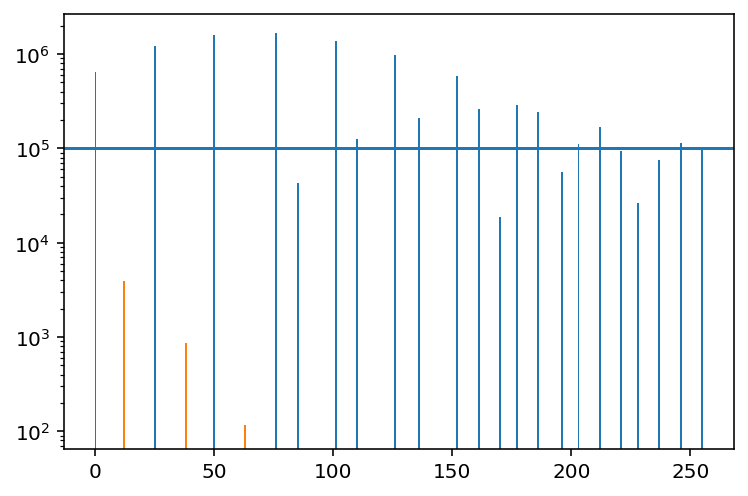

In [73]:
plt.bar(x,y)
plt.yscale("log")
plt.axhline(yth)
take = x[y<yth]
take = take[take<xth]

tmp = pixelSample
tmp = tmp[np.isin(tmp,take)]
x_noise,y_noise = np.array(tally(tmp)).T
plt.bar(x_noise,y_noise)

In [74]:
showTransposed = True

CPU times: user 30.3 ms, sys: 22.8 ms, total: 53.2 ms
Wall time: 49.5 ms


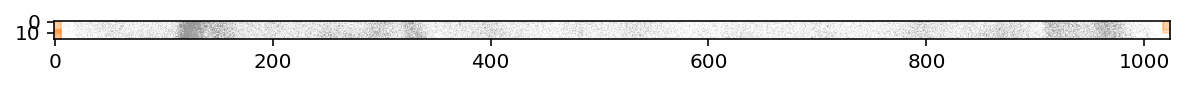

In [75]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in zip(*np.where(np.isin(ims[:],take))):
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [76]:
Nsample = int(1e7)
pixelSampleRed = np.random.choice(image.T[1:-1].flatten(), Nsample)
xRed,yRed = np.array(tally(pixelSampleRed)).T

In [77]:
tmp = xRed[yRed>yth]
tmp = tmp[tmp<xth]
meanDiff = np.diff(tmp).mean()

del tmp

In [78]:
meanDiff

25.333333333333332

In [79]:
collectBulk = [xRed[0]]
for el in xRed[1:-1]:
    if np.abs(el-collectBulk[-1]-meanDiff)<1.5:
        collectBulk += [el]

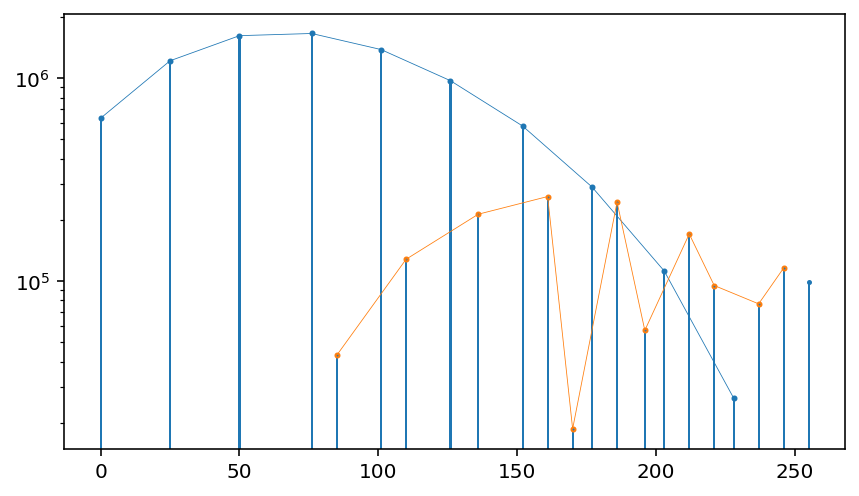

In [80]:
plt.figure(figsize=(7,4))
plt.bar(xRed,yRed,color="C0")
plt.plot(xRed,yRed,".-", ms=3, lw=0,color="C0")
plt.yscale("log")

fltr = np.isin(xRed, collectBulk)
for xf,yf in [
    (xRed[ fltr], yRed[ fltr]),
    (xRed[~fltr], yRed[~fltr]),
]:
    ff = xf!=xRed.max()
    xf = xf[ff]
    yf = yf[ff]
    plt.plot(xf,yf,".-", ms=4, lw=.4, mfc="none")

In [81]:
scale = np.diff(xRed[fltr]).mean()

In [82]:
np.diff(xf)

array([25, 26, 25,  9, 16, 10, 16,  9, 16,  9])

CPU times: user 49.8 ms, sys: 3.11 ms, total: 52.9 ms
Wall time: 50.4 ms


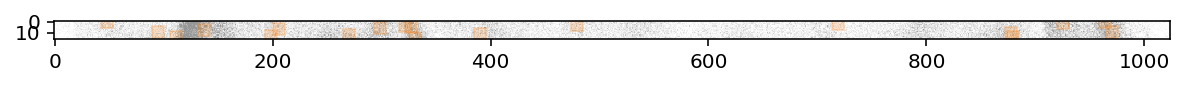

In [83]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in list(zip(*np.where(np.isin(ims[:],xf))))[::100]:
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [84]:
# ## See features

# pd.options.display.max_rows = 100

# tmp = OrderedDict([(k,v) for k,v in constFeatures.items() if
#                                 "Filter" not in k and
#                                 "Channel" not in k and
#                                 "csLutName" not in k
#                                ])
# tmp.update(features.loc[Name])
# tmp = OrderedDict([(k.replace("|"," | "),v) for k,v in tmp.items()])
# tmp = pd.DataFrame(tmp, index=[0]).T
# print (len(tmp))
# tmp

In [85]:
# features[[c for c in features.columns if "nDelayTime" in c]]

# Choose ROI(s) and try analysis

In [86]:
TotalTime = features["DimensionDescription|Length"].loc[Name]

In [87]:
TotalTime

8.297

In [88]:
Frequency = dimensions["T"]/TotalTime

In [90]:
Frequency,Frequency*12

(82.55996211509493, 990.7195453811391)

In [91]:
timeStd = np.std(image, axis=0)

In [92]:
image.shape

(685, 16, 1024)

In [107]:
if Name == "Series051":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
        (np.arange(110,150),
         np.arange( 18, 31)),
        (np.arange(330,370),
         np.arange(  1, 18)),    
        (np.arange(390,410),
         np.arange(  1, 30)),    
        (np.arange(420,450),
         np.arange( 18, 31)),    
    ]
    

if Name == "Series052":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
    ]
    RFs += [
        (np.arange(xx,xx+80),
         np.arange(dimensions["Y"])) for xx in [30,140,270,360]]    

RFs = OrderedDict(zip(range(len(RFs)),RFs))

In [116]:
list(map(lambda xi: len(xi[0]),RFs.values()))

[1024, 80, 80, 80, 80]

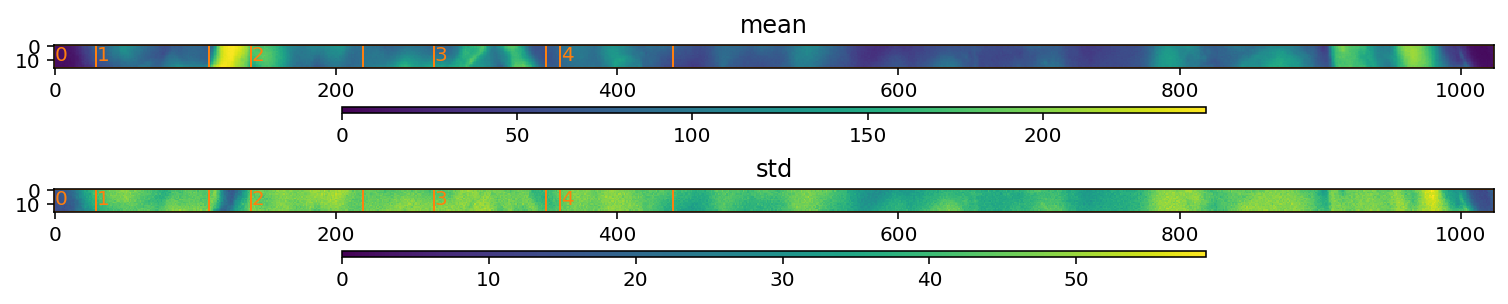

In [108]:
fig = plt.figure(figsize=(10,2))
if showTransposed:
    axs  = [fig.add_axes([  0,.07,1 ,.45]),fig.add_axes([ 0 ,.57, 1,.45]),]
    caxs = [fig.add_axes([0.2,.10,.6,.02]),fig.add_axes([0.2,.60,.6,.02]),]
else:
    axs  = [fig.add_axes([ 0 ,0,.4 ,1]),fig.add_axes([.5 ,0,.4 ,1]),]
    caxs = [fig.add_axes([.41,0,.02,1]),fig.add_axes([.91,0,.02,1]),]


for X,ax,cax,name in zip([timeStd,np.mean(image,axis=0)],axs,caxs,["std","mean"]):
    if not showTransposed:X = X.T
    im_ = ax.imshow(X, vmin=0)
    plt.colorbar(im_, cax=cax,orientation="horizontal")
    ax.set_title(name)
    ir = 0
    for rfname in RFs:
        regionFilter = RFs[rfname]
        roi = Rectangle(
            (regionFilter[0].min()-.5,regionFilter[1].min()-.5),
            width=len(regionFilter[0]),
            height=len(regionFilter[1]),
            fill=False,
            edgecolor="C1"
        )
        ax.add_patch(roi)
        ax.text(regionFilter[0].min(),regionFilter[1].min(),rfname,color="C1",va="top")
        ir+=1


In [186]:
time = np.linspace(0,TotalTime,dimensions["T"])

In [187]:
AllProfiles = OrderedDict()

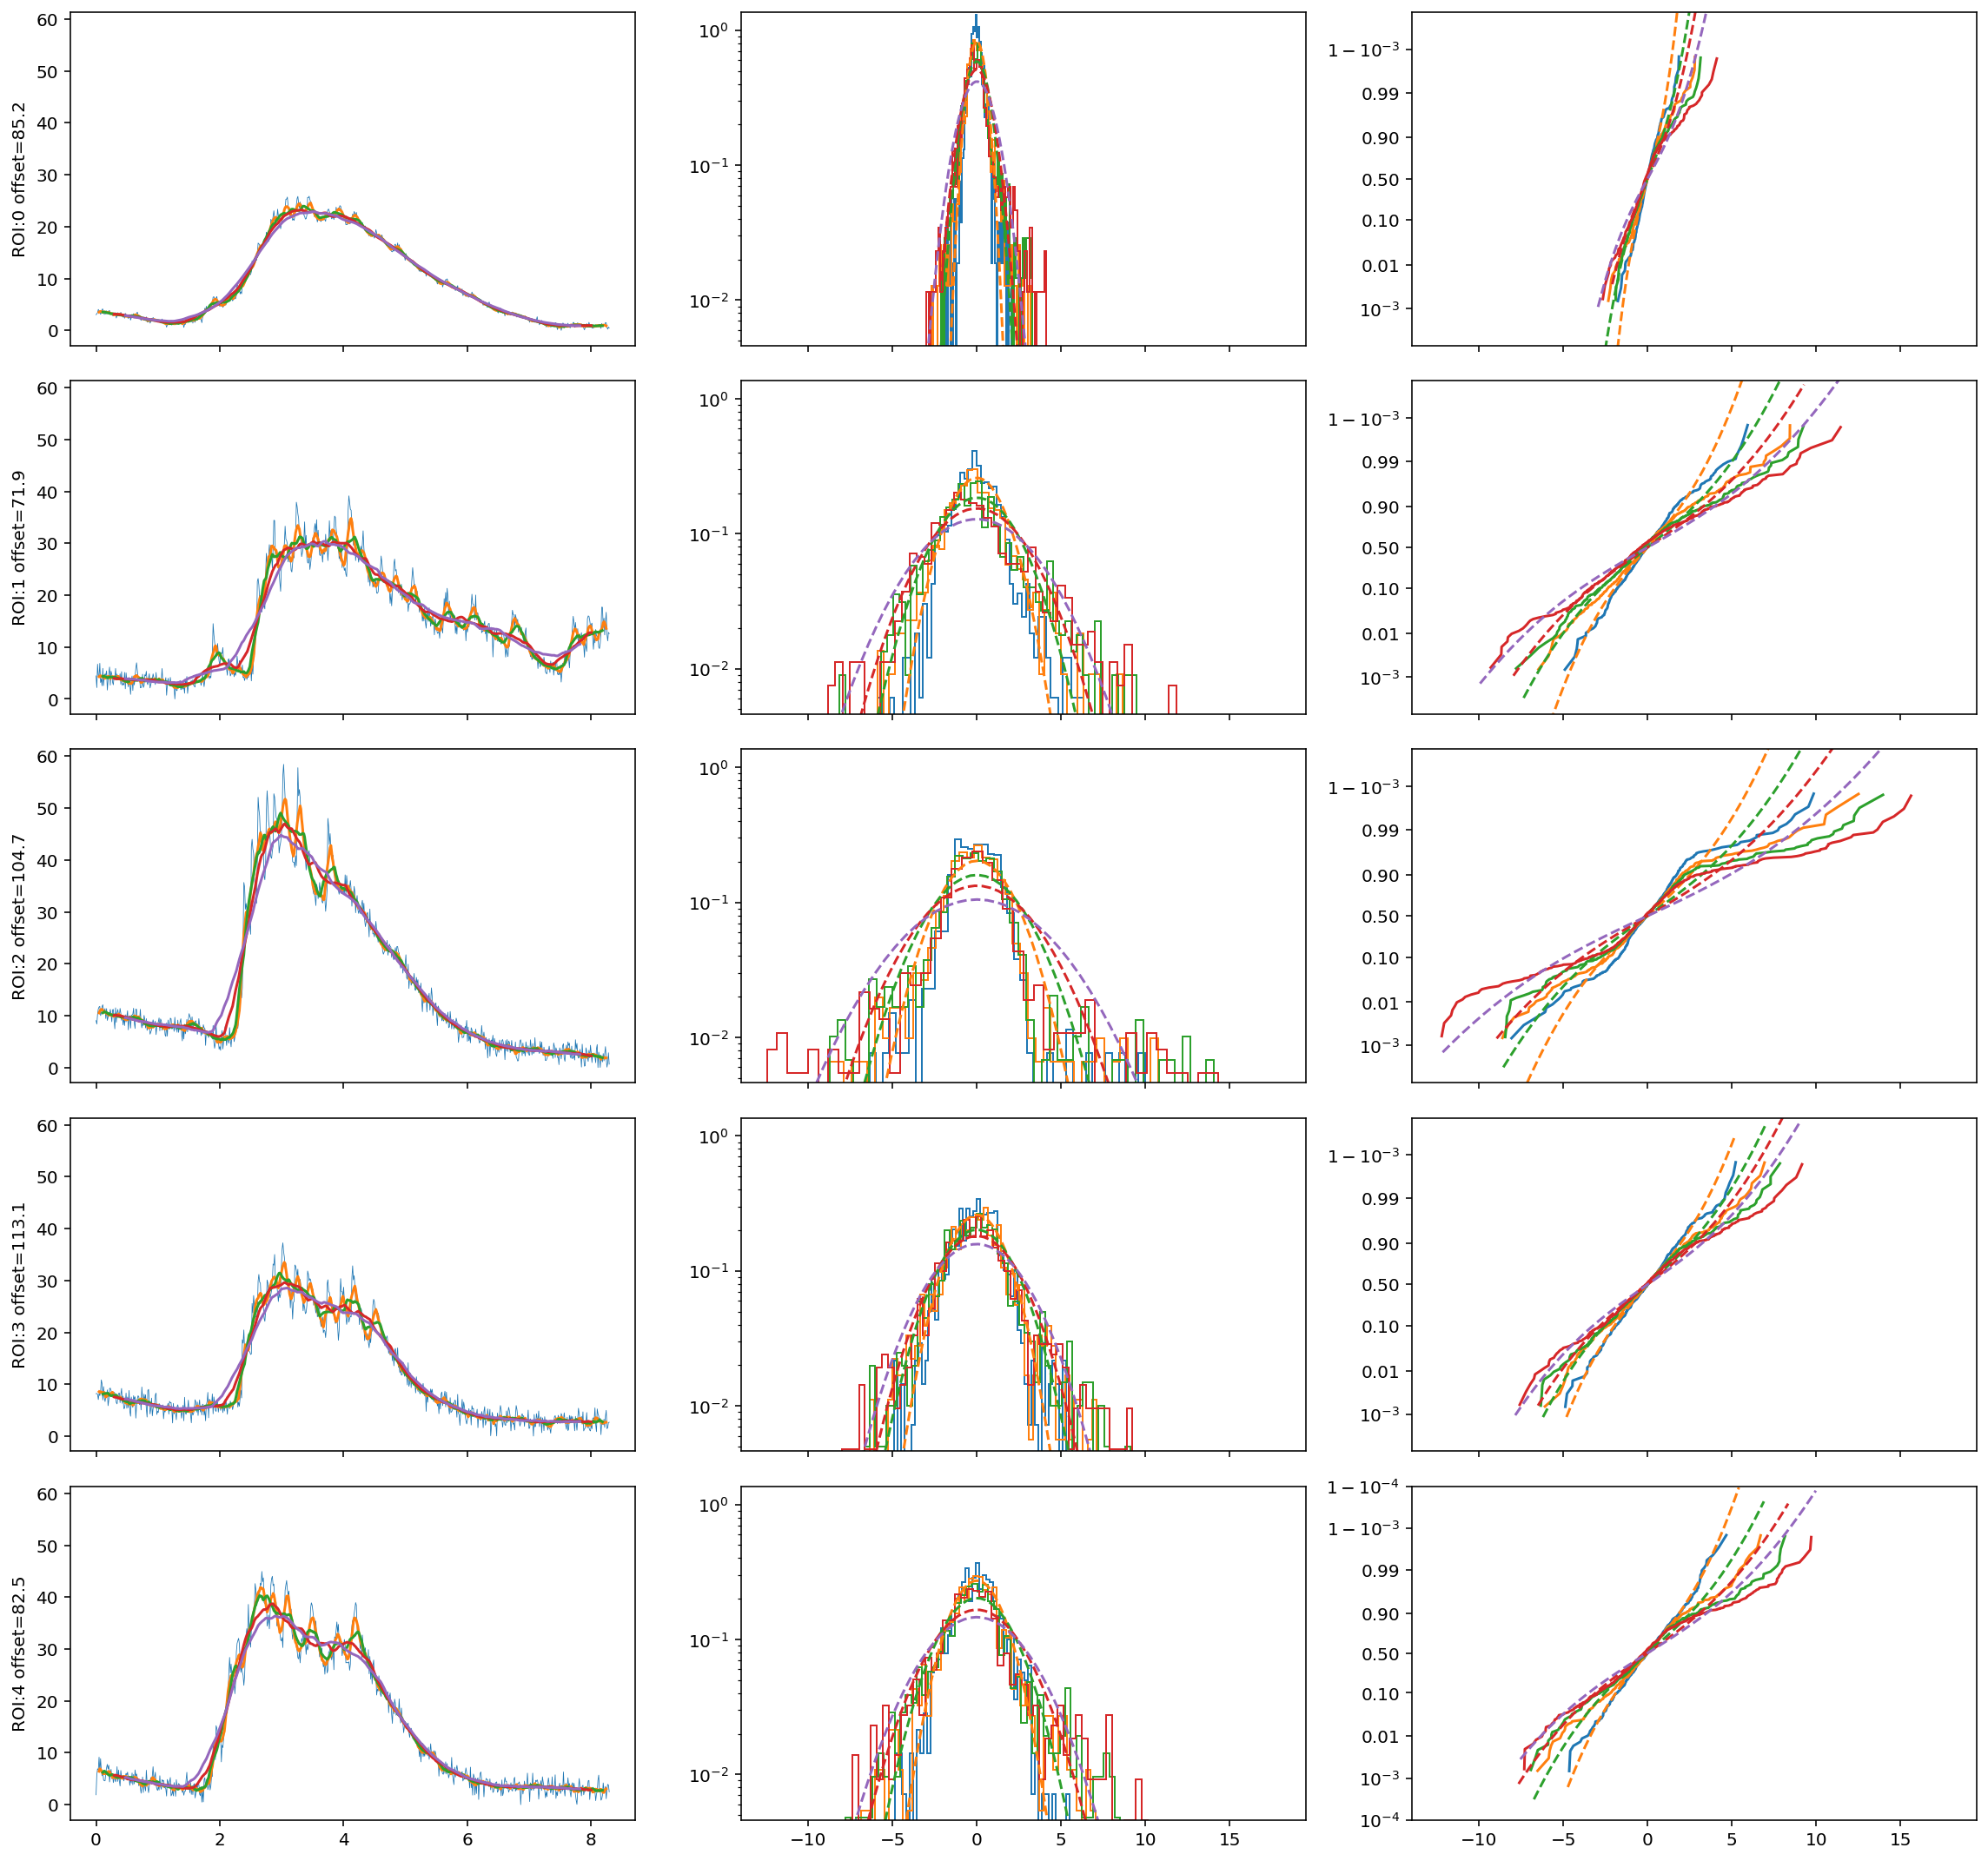

In [188]:
# showRFs = {0:RFs[0]}
showRFs = RFs
fig, Axs = plt.subplots(len(showRFs),3,figsize=(16,3*len(showRFs)), sharex="col", sharey="col")
if len(Axs.shape)==1:
    Axs=Axs.reshape(1,-1)

for ir,rfname in enumerate(showRFs):
    regionFilter = RFs[rfname]
    axs = Axs[ir]
    timeProfile = np.mean(image.T[np.ix_(*regionFilter)].T, axis=(1,2))
    offset = timeProfile.min()
    axs[0].plot(time,timeProfile-offset,lw=.4)
    profileAverages = OrderedDict([("raw",timeProfile)])
    for dtAvg in [10,20,50,80]:
        dtAvg -= 1
        timeProfileAvg = moving_average(timeProfile,dtAvg)
        timeAvg = moving_average(time, dtAvg)
        rest = timeProfile[dtAvg//2:-(dtAvg//2)]-timeProfileAvg
        profileAverages[dtAvg+1] = pd.DataFrame(OrderedDict([
            ("time", timeAvg),
            ("smooth", timeProfileAvg),
            ("rest", rest),
        ]))
        c = axs[0].plot(timeAvg,timeProfileAvg-offset,
#                         label="offset=%.1f"%timeProfileAvg.mean()
                       )[0].get_color()
        yb,bbs,_ = axs[1].hist(rest,50,histtype="step",density=True)
        xb = (bbs[:-1]+bbs[1:])/2
        restStd = rest.std()
        axs[1].plot(xb,dst.norm.pdf(xb,scale=restStd),c=c,ls="--")
        x = rest.copy()
        axs[1].set_ylim(yb[yb>0].min(),)
        axs[2].plot(sorted(x),np.linspace(0,1,len(x)))
        axs[2].plot(xb,dst.norm.cdf(xb,scale=restStd),c=c,ls="--")
#     axs[0].legend()
    axs[0].set_ylabel("ROI:%s offset=%.1f"%(repr(rfname),offset))
    axs[1].set_yscale("log")
    axs[2].set_yscale("logit")
    axs[2].set_yticks(axs[2].get_yticks())
    yx = axs[2].yaxis
    l = yx.get_minor_locator()
    l.minor = False
#     break
    AllProfiles[rfname] = profileAverages
fig.tight_layout()

<IPython.core.display.Javascript object>


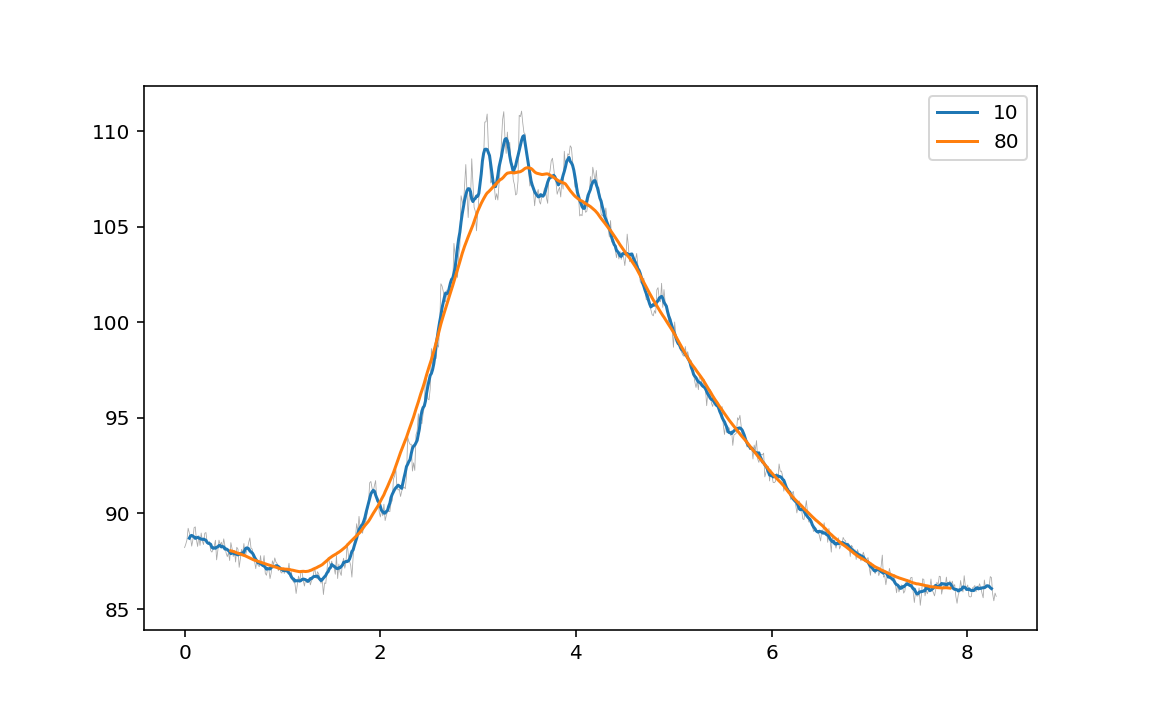

In [200]:
from importlib import reload
reload(plt)
%matplotlib notebook


plt.figure(figsize=(8,5))
rfname = 0
tmp = AllProfiles[rfname]
# for dtAvg in tmp:
for dtAvg in ["raw",10,80]:
    if dtAvg=="raw":
        plt.plot(time,tmp["raw"],color="darkgrey",lw=.4)
    else:
        t,x = tmp[dtAvg][["time","smooth"]].values.T
        plt.plot(t,x,label=dtAvg)
plt.legend()

In [144]:
filename, Name

('Experiment.lif', 'Series052')

## FFT

In [ ]:
%matplotlib inline

In [148]:
trace1 = tmp["raw"]
dt  = TotalTime/len(trace1)
FTs = np.fft.fft(trace1)
N   = len(trace1)
freqs = np.fft.fftfreq(N,dt)
FAs = np.abs(FTs)


In [157]:
PowerSpectrum = FAs**2/(1/dt)**2
print (np.sum(PowerSpectrum)*freqs[1])
print (np.sum(trace1**2)*dt)

74191.03164121747
74191.03164121746


In [179]:
filterF = lambda x: x**2/(100.**2+x**2)

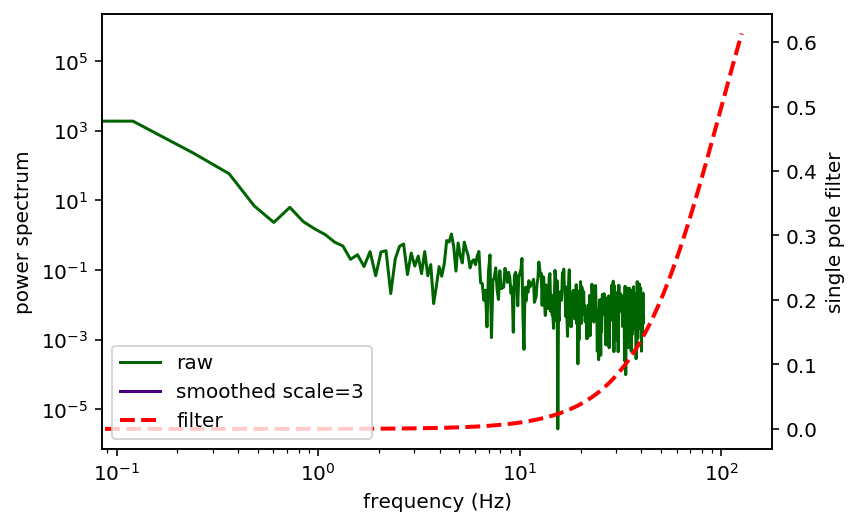

In [180]:

Nshow = N//2
l1 = plt.plot(freqs[:Nshow],PowerSpectrum[:Nshow], label='raw',
              color="darkgreen")
# smooth = 3
# l2 = plt.plot(freqs[smooth//2:Nshow-smooth//2],
#          moving_average(PowerSpectrum[:Nshow], smooth),
#               label='smoothed scale=%i'%smooth, color="indigo")

plt.ylabel('power spectrum')
plt.xlabel('frequency (Hz)')
# plt.xlim(2*freqs[1],10.**3.9)
plt.yscale('log')
plt.xscale('log')
plt.twinx()
# plt.xlim(2*freqs[1],10.**3.9)

xr = np.logspace(-2,2.1, 201)

l3 = plt.plot(xr,filterF(xr), label="filter", color="red", ls="--",lw=2)
plt.ylabel('single pole filter')

lns = l1+l2+l3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=3)

In [181]:
filteredFT = FTs*filterF(freqs)**.5

In [182]:
filteredTrace = np.fft.ifft(filteredFT)

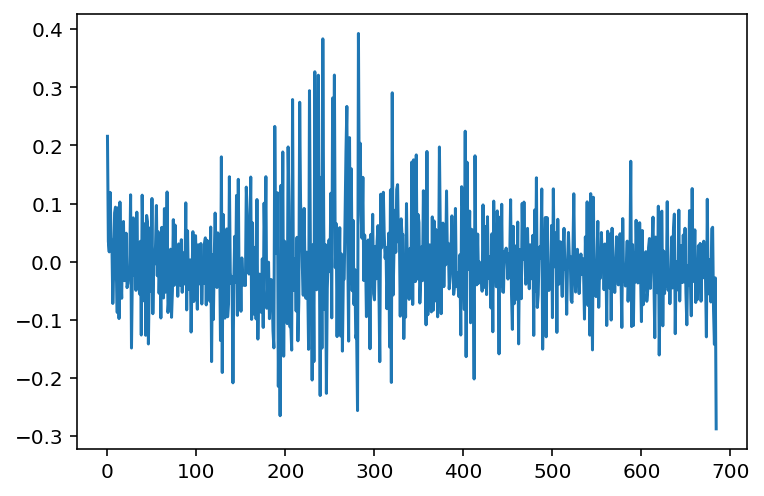

In [183]:
plt.plot(np.real_if_close(filteredTrace))

In [185]:
filteredTrace.shape, trace1.shape

((685,), (685,))

In [103]:
# "freq" in 
k = list(constFeatures.keys())[0]
k.lower(),np.isin(["inc","|"],k.lower())

('channeldescription|bitinc', array([False, False]))

In [117]:
fltrkeys = [
        "freq",
        "time",
        "dwell",
#         "length",
        "delay",
        "expo",
        "gain",
        "integ",
]
pd.concat([
    mdf.loc[idx],
    features.loc[Name,[c for c in features.columns if np.any([l in c.lower() for l in fltrkeys])]],
    pd.Series(OrderedDict([(k.replace("|"," | "),v) for k,v in constFeatures.items() if np.any([l in k.lower() for l in fltrkeys])])),
])

Name                                                                                      Series051
AcquisitionDate                                                                 2019-05-16 14:14:16
X                                                                                               512
Y                                                                                                32
T                                                                                             12524
C                                                                                                 1
Z                                                                                                 1
nAverageLine_1                                                                                    3
HardwareSetting|FilterSettingRecord|HyD 1 (Gain) #1                                              24
HardwareSetting|FilterSettingRecord|X Reson. Scan Actuator (Gain) #1                        3.09594


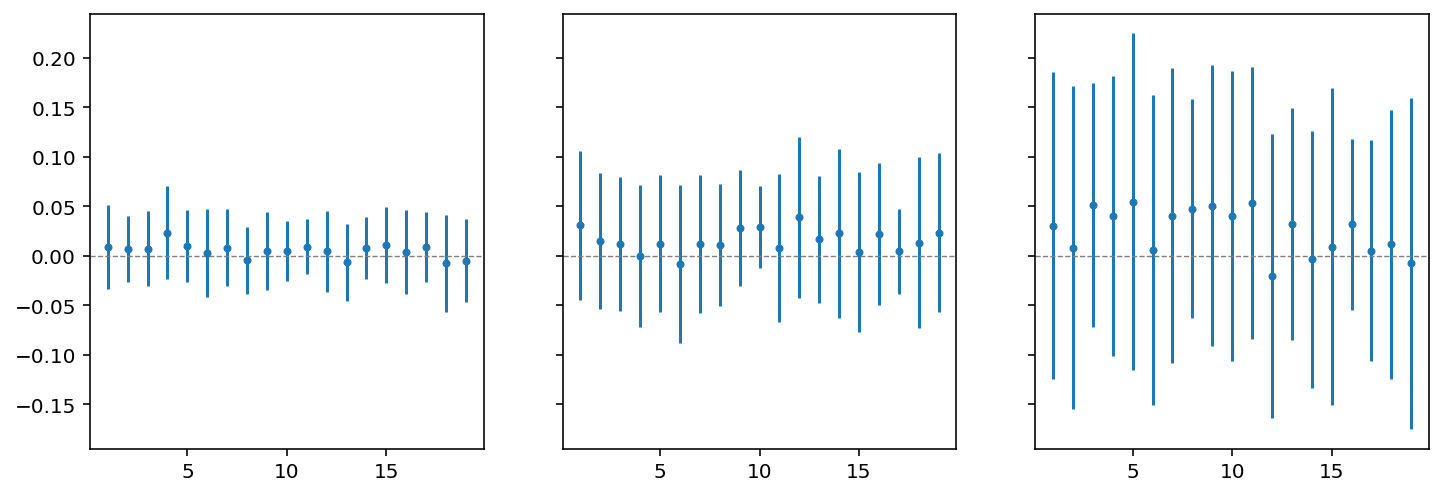

In [331]:
xr = np.arange(1,20)
dtBin = 3
nc = 3
fig, axs = plt.subplots(1,nc,figsize=(nc*4,4), sharex=True, sharey=True)
for i in range(nc):
    ax = axs.flat[i]
#     plt.subplot(1,nc,i+1)
    if i==0:
        X = timeProfile.copy()
    else:
        nTime = len(X)
        X = X[:nTime//dtBin*dtBin].reshape(nTime//dtBin,dtBin).mean(axis=1)
    yr, ye = autocorr(X, xr,nsplits=20)
    ax.errorbar(xr,yr,ye,ls="none",marker=".")
    ax.axhline(0,color='grey', ls="--", lw=.7)
#     plt.show()

(-13.190000000000001, 268.19)

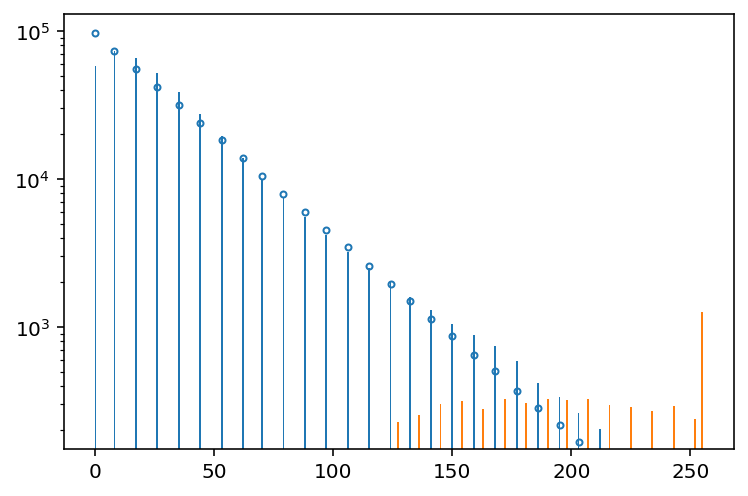

In [51]:


realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

<BarContainer object of 7 artists>

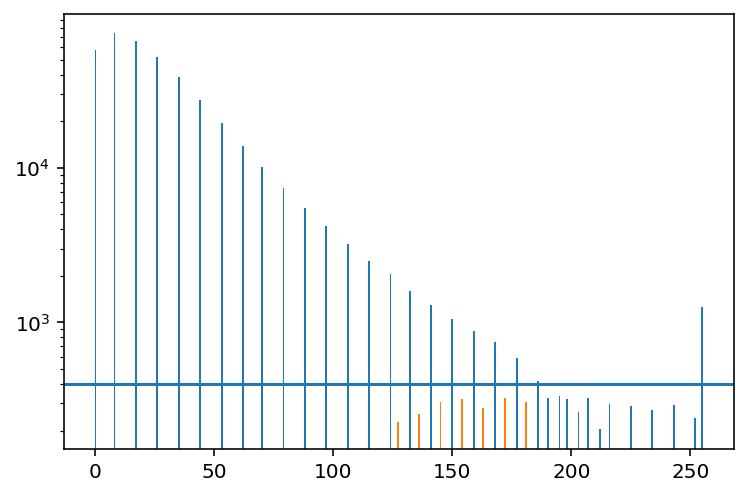

In [48]:
th = 4e2
plt.axhline(th)
take = x[y<th]
take = take[take<190]

tmp = tmp[np.isin(tmp,take)]
x,y = np.array(tally(tmp)).T
plt.bar(x,y)

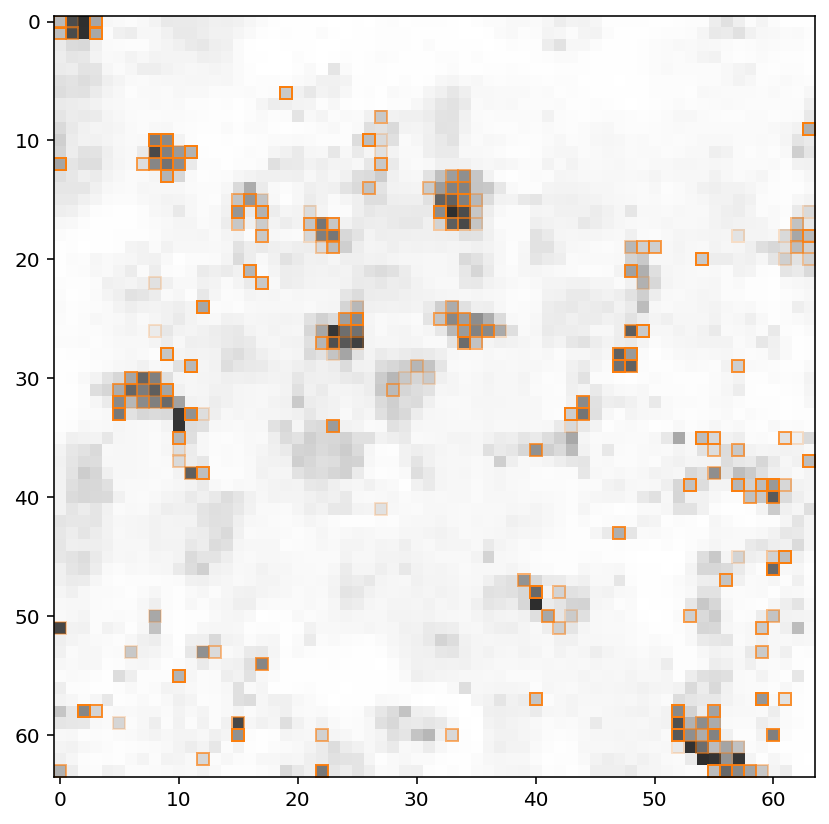

In [49]:
plt.figure(figsize=(7,7))
plt.imshow(np.mean(ims,axis=0).T, cmap="Greys",vmax=300)
for t,x,y in zip(*np.where(np.isin(ims,take))):
    plt.plot(x,y,"C1s",
             alpha = .2,
             mfc="none"
            )
    #, )#,mec="C1")

In [85]:
from scipy.stats import distributions as dst

(-13.190000000000001, 268.19)

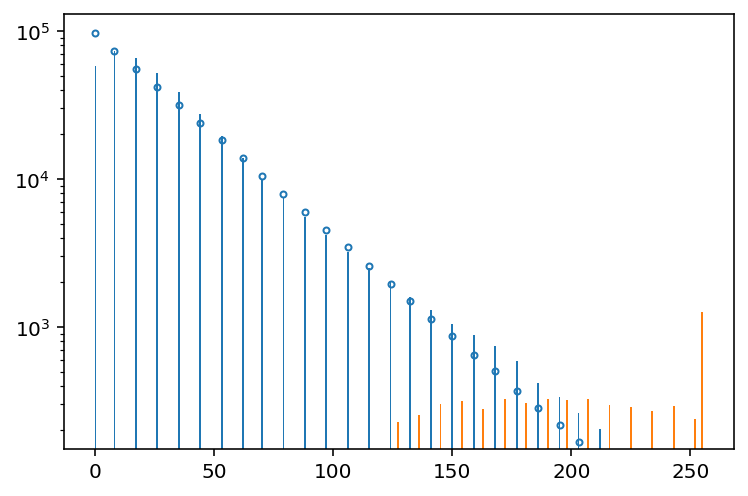

In [51]:
# x,y = np.array(tally(ims.flatten())).T
# plt.bar(x,y)

x,y = np.array(tally(ims.T[1:-1].flatten())).T
plt.bar(x,y)

plt.yscale("log")
xl = plt.xlim()

realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

In [52]:
take = xr

In [53]:
imsf = ims.astype(float)

In [54]:
imsf[~np.isin(imsf,take)] = np.nan

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


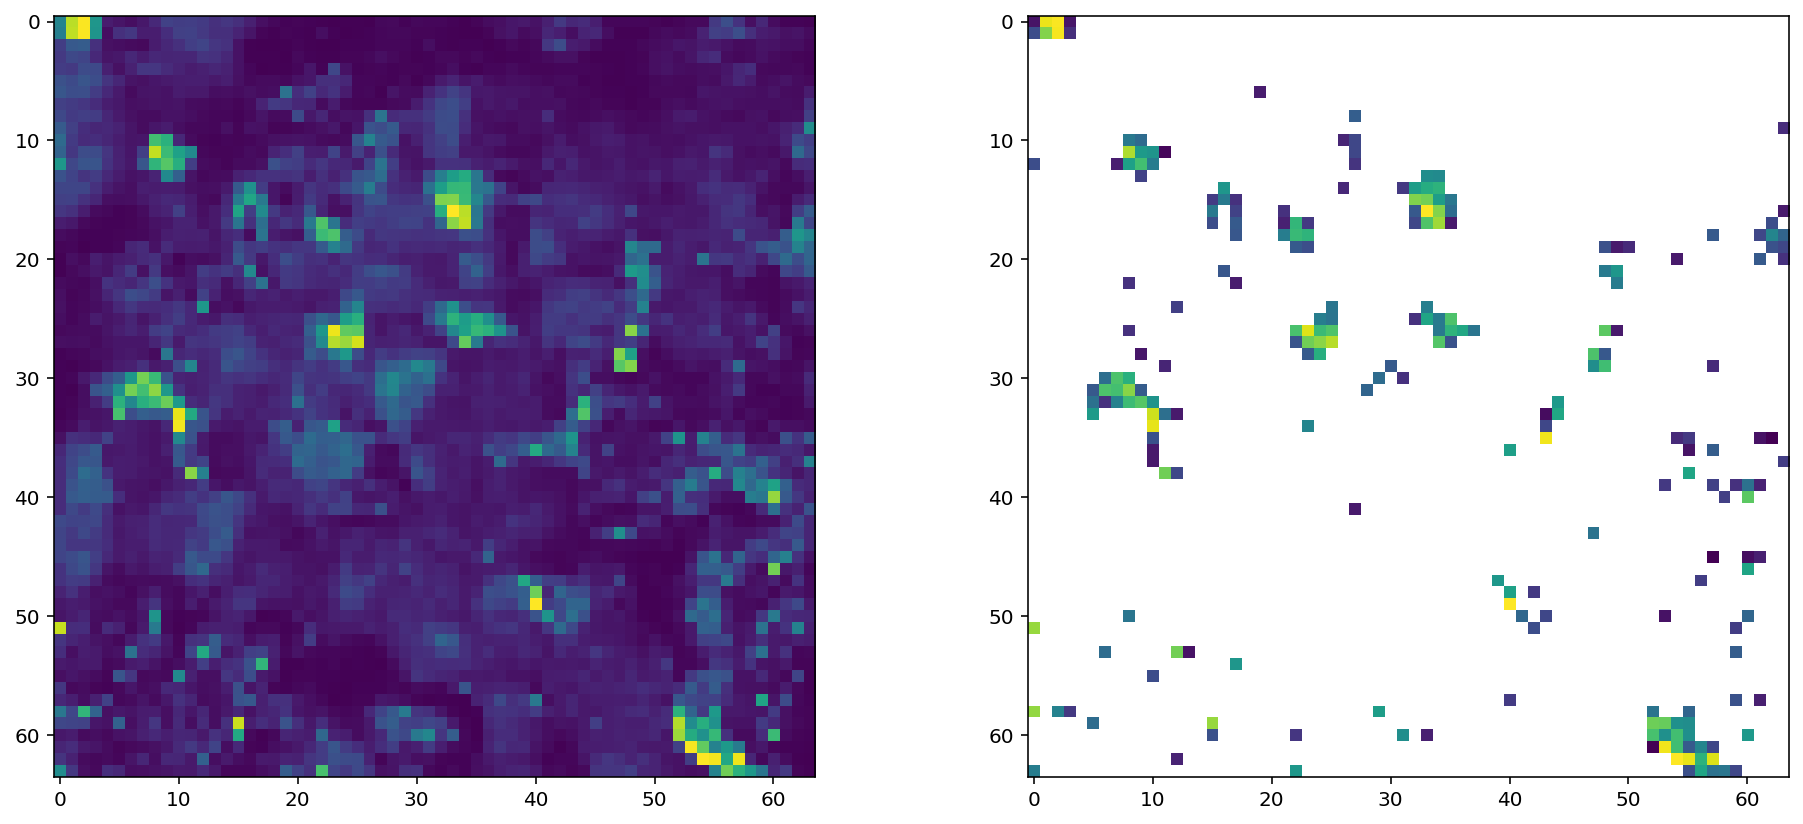

In [55]:
fig,axs = plt.subplots(1,2,figsize=(16,7))
axs[0].imshow(np.nanmean(ims ,axis=0).T)
axs[1].imshow(np.nanmean(imsf,axis=0).T)
# for t,x,y in zip(*np.where(np.isin(ims[::1000],take))):
#     plt.plot(x,y,"C1s",
#              alpha = .2,
#              mfc="none"
#             )
#     #, )#,mec="C1")

# Kill javabridge

In [ ]:
javabridge.kill_vm()